**Laboratory Lecture 7**

## EXAMPLE: Causal effect of rain on wet grass

Let's consider again our Sprinkler network, assuming this is a reliable description of the causal relationships between its four variables:


<img src='https://drive.google.com/uc?id=1C2vyT2X19C_IekWf3rELuF4SumvJxo2b'>

In this case we want to estimate the causal effects of the rain on the "wetness" of the grass.

Note that it wouldn't be physically possible to modify the rain variable $R$. Yet, we can use probabilities from observational data of the weather to compute its causal effect "as if" we were able to intervene on it.

To this end, we can compute the effect of the intervention $P(G = true | do(R = true))$, or simply $P(g | do(r))$, by using the adjustment formula for the only parent of $R$, which is $C$:

$$ P(g | do(r)) = \sum_{z \in C} P(g | r, z) P(z) \\ = P(g | r, c) P(c) + P(g | r, \neg c) P(\neg c) $$

The probability distribution ${\bf P}(C) = \langle P(c), P(\neg c) \rangle$ is already given by the network. The conditional distribution ${\bf P}(G | r, c) = \langle P(g | r, c), P(\neg g | r, c)\rangle$ can be computed as follows:

$$
{\bf P}(G | r, c) = \dfrac{{\bf P}(G, r, c)}{P(r, c)} = \alpha {\bf P}(G, r, c) = \alpha \sum_s {\bf P}(G, r, c, s) \\
= \alpha \sum_s P(c) P(r|c) P(s|c) {\bf P}(G | r, s) \\
= \alpha P(c) P(r|c) \sum_s  P(s|c) {\bf P}(G | r, s) \\
= \alpha' \sum_s  P(s|c) {\bf P}(G | r, s) \\
= \alpha' \big[ P(s|c) {\bf P}(G | r, s) + P(\neg s|c) {\bf P}(G | r, \neg s) \big]
$$

where in the last steps we moved the product $P(c) P(r|c)$ within the normalisation factor $\alpha'$.

Substituting the values from the network's CPTs, we get the following:

$
{\bf P}(G | r, c) = \alpha' \big[ 0.1 \times \langle 0.95, 0.05 \rangle + 0.9 \times \langle 0.90, 0.10 \rangle \big] = \langle 0.905, 0.095 \rangle
$

If we do the same for the condition $\neg c$, we obtain the following distribution:

$
{\bf P}(G | r, \neg c) = \alpha' \big[ 0.5 \times \langle 0.95, 0.05 \rangle + 0.5 \times \langle 0.90, 0.10 \rangle \big] = \langle 0.925, 0.075 \rangle
$

Finally, we use the calculated values, $P(g | r, c) = 0.905$ and $P(g | r, \neg c) = 0.925$, in the previous adjustment formula and obtain the following:

$
P(g | do(r)) = 0.905 \times 0.5 + 0.925 \times 0.5 = 0.915
$

which is our causal effect of the intervention $R = true$ on the wetness $G = true$.




## EXAMPLE: Simpson’s Paradox

This notebook follows the famous example from Causality (Pearl, 2009) and the documentation in the pyAgrum website. 

In [34]:
from IPython.display import display, Math, Latex

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

In a statistical study about a drug, we try to evaluate the latter’s efficiency among a population of men and women. Let’s note: - Drug
 : drug taking - Patient
 : cured patient - Gender
 : patient’s gender

 The model from the observed date is as follow :

In [35]:
m1 = gum.fastBN("Gender{F|M}->Drug{Without|With}->Patient{Sick|Healed}<-Gender")

m1.cpt("Gender")[:]=[0.5,0.5]
m1.cpt("Drug")[:]=[[0.25,0.75],  #Gender=F
                   [0.75,0.25]]  #Gender=M

m1.cpt("Patient")[{'Drug':'Without','Gender':'F'}]=[0.2,0.8] #No Drug, Male -> healed in 0.8 of cases
m1.cpt("Patient")[{'Drug':'Without','Gender':'M'}]=[0.6,0.4] #No Drug, Female -> healed in 0.4 of cases
m1.cpt("Patient")[{'Drug':'With','Gender':'F'}]=[0.3,0.7] #Drug, Male -> healed 0.7 of cases
m1.cpt("Patient")[{'Drug':'With','Gender':'M'}]=[0.8,0.2] #Drug, Female -> healed in 0.2 of cases
gnb.flow.row(m1,m1.cpt("Gender"),m1.cpt("Drug"),m1.cpt("Patient"))

In [36]:
def getCuredObservedProba(m1,evs):
    evs0=dict(evs)
    evs1=dict(evs)
    evs0["Drug"]='Without' 
    evs1["Drug"]='With'
    
    return gum.Potential().add(m1.variableFromName("Drug")).fillWith([
            gum.getPosterior(m1,target="Patient",evs=evs0)[1],
            gum.getPosterior(m1,target="Patient",evs=evs1)[1]
        ])
    

gnb.sideBySide(getCuredObservedProba(m1,{}),
               getCuredObservedProba(m1,{'Gender':'F'}),
               getCuredObservedProba(m1,{'Gender':'M'}),
               captions=["$P(Patient = Healed \mid Drug )$<br/>Taking $Drug$ is observed as efficient to cure",
                         "$P(Patient = Healed \mid Gender=F,Drug)$<br/>except if the $gender$ of the patient is female",
                         "$P(Patient = Healed \mid Gender=M,Drug)$<br/>... or male."])

Those results form a paradox called Simpson paradox :

$$
P(C | \neg D) = 0.5 < P(C |D) = 0.575\\
P(C | \neg D, G = Male) = 0.8 > P(C |D, G= Male) = 0.7\\
P(C | \neg D, G = Female) = 0.4 > P(C |D, G= Female) = 0.2\\
$$

Actually, giving a drug is not an observation in our model but rather an intervention. What if we use intervention instead of observation ?

How to compute causal impacts on the patient’s health ?
We propose this causal model.

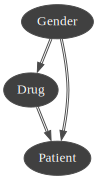

In [37]:
d1 = csl.CausalModel(m1)
cslnb.showCausalModel(d1)

Computing P(Patient=Healed∣↪Drug=Without)

In [38]:
cslnb.showCausalImpact(d1, "Patient", doing="Drug",values={"Drug" : "Without"})

Computing  P(Patient=Healed∣↪Drug=With)

In [39]:
d1 = csl.CausalModel(m1)
cslnb.showCausalImpact(d1, "Patient", "Drug",values={"Drug" : "With"})

And then : $P(Patient=Healed∣↪Drug=With) = 0.45 $

Therefore : $P(Patient=Healed∣↪Drug=Without) = 0.6 > P(Patient=Healed∣↪Drug=With) = 0.45 $

Which means that taking this drug would not enhance the patient’s healing process, and it is better not to prescribe this drug for treatment.


Simpson paradox solved by interventions

So to summarize, the paradox appears when wrongly dealing with observations on Drug
 :

In [40]:
gnb.sideBySide(getCuredObservedProba(m1,{}),
               getCuredObservedProba(m1,{'Gender':'F'}),
               getCuredObservedProba(m1,{'Gender':'M'}),
               captions=["$P(Patient = Healed \mid Drug )$<br/>Taking $Drug$ is observed as efficient to cure",
                         "$P(Patient = Healed \mid Gender=F,Drug)$<br/>except if the $gender$ of the patient is female",
                         "$P(Patient = Healed \mid Gender=M,Drug)$<br/>... or male."])

… and disappears when dealing with intervention on Drug:

In [41]:
gnb.sideBySide(csl.causalImpact(d1,on="Patient",doing="Drug",values={"Patient":"Healed"})[1],
               csl.causalImpact(d1,on="Patient",doing="Drug",knowing={"Gender"},values={"Patient":"Healed","Gender":"F"})[1],
               csl.causalImpact(d1,on="Patient",doing="Drug",knowing={"Gender"},values={"Patient":"Healed","Gender":"M"})[1],
               captions=["$P(Patient = 1 \mid \hookrightarrow Drug )$<br/>Effectively $Drug$ taking is not efficient to cure",
                         "$P(Patient = 1 \mid \hookrightarrow Drug, gender=F )$<br/>, the $gender$ of the patient being female",
                         "$P(Patient = 1 \mid \hookrightarrow Drug, gender=M )$<br/>, ... or male."])